In [26]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_5956/2891261325.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create and inspect the data

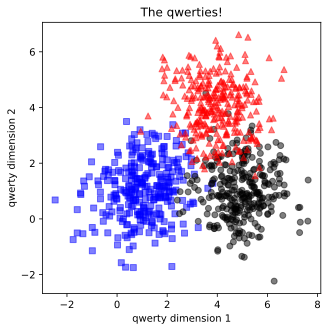

In [27]:
# Parameters
n_per_clust = 300
blur        = 1
A           = [1, 1]
B           = [5, 1]
C           = [4, 4]

# Generate data
a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

# Concatanate into a matrix
data_np   = np.hstack(tup=(a, b, c)).T

# True labels
labels_np = np.hstack(tup=(np.zeros(shape=(n_per_clust)), 
                           np.ones(shape=(n_per_clust)),
                           1 + np.ones(shape=(n_per_clust))))

# Convert to a pytorch tensor
data   = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# Show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs', alpha=0.5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', alpha=0.5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], 'r^', alpha=0.5)

plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [28]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset  = TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
train_batch_size = 16
test_batch_size  = test_dataset.tensors[0].shape[0]
train_loader     = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader      = DataLoader(dataset=test_dataset,  batch_size=test_batch_size)

# How many batches are there?
print(f'There are {len(train_loader)} batches, each with {train_batch_size} samples')

There are 50 batches, each with 16 samples


# Create and validate the model

In [29]:
def create_the_qwety_net():
    class qwerty_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear (2, 8)

            # Hidden layer
            self.fc1 = nn.Linear(8, 8)

            # Output layer
            self.output = nn.Linear(8, 3)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = self.output(x)

            return x
        
    # Create the model instance
    net = qwerty_net()
    
    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01)

    return net, loss_func, optimizer

In [30]:
# Test the model with fake input
net, loss_func, optimizer = create_the_qwety_net()
print(net)

# Input is ten samples
input = torch.rand(10, 2)
net(input)

qwerty_net(
  (input): Linear(in_features=2, out_features=8, bias=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=3, bias=True)
)


tensor([[ 0.5017, -0.1071, -0.2873],
        [ 0.4421, -0.1398, -0.2691],
        [ 0.4621, -0.1315, -0.2722],
        [ 0.4563, -0.1300, -0.2769],
        [ 0.4579, -0.1441, -0.2566],
        [ 0.4627, -0.1200, -0.2876],
        [ 0.5019, -0.1133, -0.2788],
        [ 0.4777, -0.1113, -0.2925],
        [ 0.4924, -0.1088, -0.2891],
        [ 0.4459, -0.1364, -0.2724]], grad_fn=<AddmmBackward0>)

# A function that trains the model

In [31]:
def train_the_model():
  num_epochs = 100
  
  net, loss_func, optimizer = create_the_qwety_net()

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    net.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    net.eval()                 # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      # pred_labels = torch.argmax(net(X), axis=1)
      pred_labels = net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((torch.argmax(pred_labels, axis=1)) == y).float()))

  # Function output
  return train_acc, test_acc, losses, net

# Run the model and plot the results

In [32]:
# Run the model
train_acc, test_acc, losses, net = train_the_model()

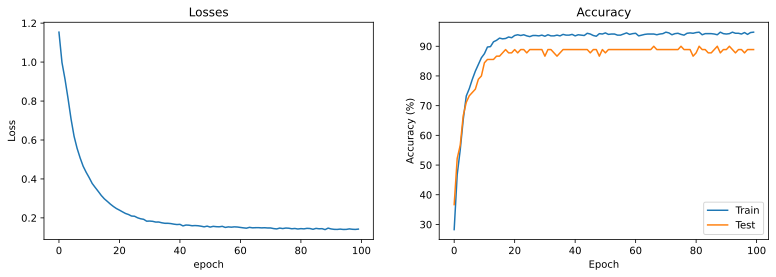

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(train_acc, label='Train')
ax[1].plot(test_acc, label='Test')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

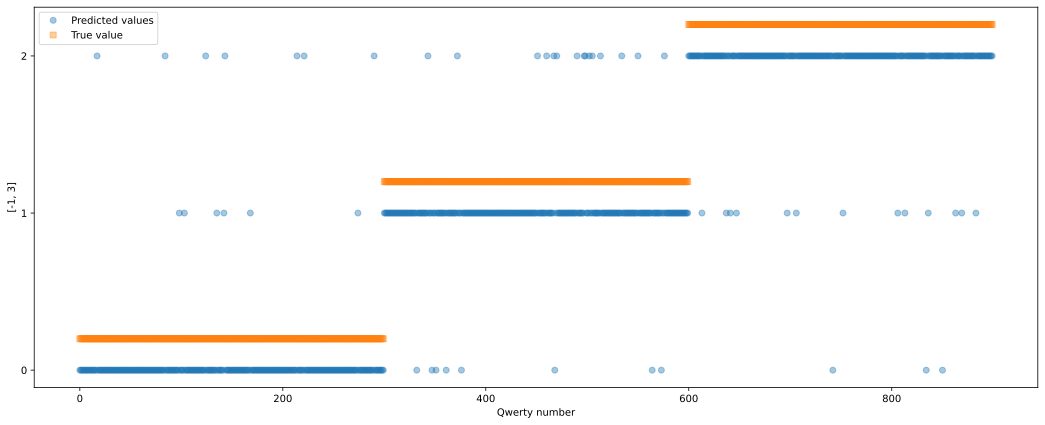

In [34]:
# Run the data through the model to get the categorical predictions
y_hat       = net(data)
predictions = torch.argmax(y_hat, axis=1)

# And plot those against the real data
plt.figure(figsize=(18, 7))
plt.plot(predictions, 'o', label='Predicted values', alpha=0.4)
plt.plot(labels + 0.2, 's', label='True value', alpha=0.4)
plt.xlabel('Qwerty number')
plt.ylabel('Category')
plt.yticks([0, 1, 2])
plt.ylabel([-1, 3])
plt.legend()
plt.show()

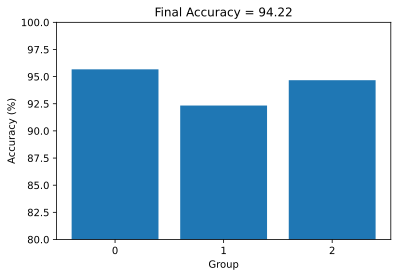

In [35]:
# Recode each prediction by accuracy
accuracy = (predictions == labels).float()

# Compute overall accuracy
total_acc = torch.mean(100 * accuracy).item()

# And average by group
accuracy_by_group = np.zeros(3)

for i in range(3):
  accuracy_by_group[i] = 100 * torch.mean(accuracy[labels == i])

plt.bar(range(3), accuracy_by_group)
plt.ylim([80, 100])
plt.xticks([0, 1, 2])
plt.xlabel('Group')
plt.ylabel('Accuracy (%)')
plt.title(f'Final Accuracy = {total_acc:.2f}')
plt.show()

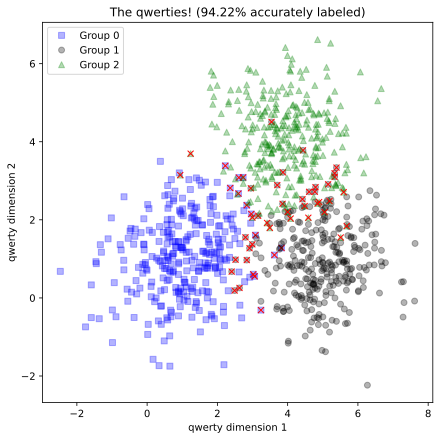

In [38]:
# Finally, show the data in their native space, labeled by accuracy
number_classes = 3
# Data markers
colors_shapes = ['bs', 'ko', 'g^']

# Show the data
fig = plt.figure(figsize=(7, 7))

# Plot correct and incorrect labeled data
for i in range(number_classes):
    # Plot all data points for this label
    plt.plot(data[labels == i, 0], data[labels == i, 1], colors_shapes[i], alpha=0.3, label=f'Group {i}')
    
    # Cross out the incorrect ones
    idx_error = (accuracy == 0) & (labels == i)
    plt.plot(data[idx_error, 0], data[idx_error, 1], 'rx')

plt.title(f'The qwerties! ({total_acc:.2f}% accurately labeled)')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()

# Additional explorations
1) There are three categories and 8 units in the hidden layer. Is that more units than we need? Try re-running the model
   with 3 units insted of 8. Does the model still perform well? Does it perform equally well on all three categories?

2) One of the advantages of using simulated data is that you can have as much -- or as little -- data as possible. This
   allows you to explore how much data the model needs for learning. Re-run this notebook using N=50/cluster (nb: you 
   might want to adjust the minibatch size). Is that enough to get good accuracy? Now try using N=1000/cluster. You can
   run a parametric experiment to determine how model accuracy depends on the amount of data.

3) Where do you put torch.no_grad() to crash the model? That is, find the one line (or maybe there is more than one?)
   where the following crashes the model:
     with torch.no_grad():
       <key line here>

   What does your discovery tell you about where during training the gradients are computed and used?